<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_data_dataVsDepth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [4]:
# a function that creats data

def createSomeData(nPerClust):

    A = [1, 1]
    B = [5, 1]
    C = [4, 4]

    # generate data
    a = [A[0] + np.random.randn(nPerClust), A[1]+np.random.randn(nPerClust)]
    b = [B[0] + np.random.randn(nPerClust), B[1]+np.random.randn(nPerClust)]
    c = [C[0] + np.random.randn(nPerClust), C[1]+np.random.randn(nPerClust)]

    # true labels
    labels_np = np.hstack((np.zeros((nPerClust)), 
                           np.ones((nPerClust)), 
                           1+np.ones((nPerClust)) ))
    # concatenate into a matrix
    data_np = np.hstack((a, b, c)).T

    # NEW: put all outputs into a dictionary
    output = {}
    output['data'] = torch.tensor(data_np).float()
    output['labels'] = torch.tensor(labels_np).long()

    # use scikit learn to split the data
    train_data, test_data, train_labels, test_labels = train_test_split(output['data'], output['labels'], test_size=.2, shuffle=True)

    # then convert them into pytorch Datasets (note: already converted to tensors)
    train_data = TensorDataset(train_data, train_labels)
    test_data = TensorDataset(test_data, test_labels)

    # finally, translate into dataloader objects
    batchsize = 8
    output['train_data'] = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
    output['test_data'] = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

    return output

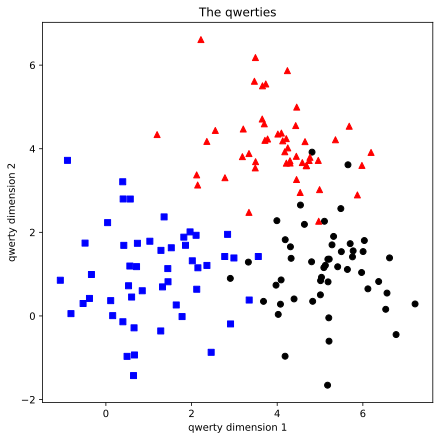

In [6]:
# check that function works
theData = createSomeData(50)

data = theData['data']
labels = theData['labels']

# show the data
fig = plt.figure(figsize=(7,7))
plt.plot(data[np.where(labels==0)[0], 0], data[np.where(labels==0)[0], 1], 'bs')
plt.plot(data[np.where(labels==1)[0], 0], data[np.where(labels==1)[0], 1], 'ko')
plt.plot(data[np.where(labels==2)[0], 0], data[np.where(labels==2)[0], 1], 'r^')
plt.title('The qwerties')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

## Create the model

In [7]:
# create a class for the model
def createTheQwertyNet(nUnits, nLayers):

    class qwertyNet(nn.Module):
        def __init__(self, nUnits, nLayers):
            super().__init__()

            # create a dictionary to store the layers
            self.layers = nn.ModuleDict()
            self.nLayers = nLayers

            ## input layer
            self.layers['input'] = nn.Linear(2, nUnits)

            ## hidden layers
            for i in range(nLayers):
                self.layers[f'hidden{i}'] = nn.Linear(nUnits, nUnits)

            ## output layer
            self.layers['output'] = nn.Linear(nUnits, 3)

        # forward pass
        def forward(self, x):

            # input layer
            x = self.layers['input'](x)

            # hidden layers
            for i in range(self.nLayers):
                x = F.relu(self.layers[f'hidden{i}'](x))

            # return output layer
            x = self.layers['output'](x)
            return x

    # create the model instance
    net = qwertyNet(nUnits, nLayers)

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=.01)

    return net, lossfun, optimizer




In [8]:
# test the model with fake input

nUnitsPerLayer = 12
nLayers = 4

net, lossf, opt = createTheQwertyNet(nUnitsPerLayer, nLayers)
print(net)

# input is then samples
input = torch.randn(10, 2)
net(input)

qwertyNet(
  (layers): ModuleDict(
    (input): Linear(in_features=2, out_features=12, bias=True)
    (hidden0): Linear(in_features=12, out_features=12, bias=True)
    (hidden1): Linear(in_features=12, out_features=12, bias=True)
    (hidden2): Linear(in_features=12, out_features=12, bias=True)
    (hidden3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=3, bias=True)
  )
)


tensor([[ 0.2606, -0.1271,  0.0213],
        [ 0.2550, -0.1312,  0.0237],
        [ 0.2554, -0.1304,  0.0248],
        [ 0.2586, -0.1272,  0.0262],
        [ 0.2553, -0.1305,  0.0246],
        [ 0.2546, -0.1315,  0.0243],
        [ 0.2551, -0.1308,  0.0249],
        [ 0.2588, -0.1276,  0.0247],
        [ 0.2583, -0.1272,  0.0320],
        [ 0.2562, -0.1291,  0.0252]], grad_fn=<AddmmBackward0>)

In [9]:

def function2trainTheModel(nUnits, nLayers):
    numepochs = 50

    # create a new model
    net, lossfun, optimizer = createTheQwertyNet(nUnits, nLayers)

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):
        
        #switch to training mode
        net.train()


        batchLoss = []
        batchAcc = []
        # loop over batches
        for X, y in train_loader:

            #forward pass
            yHat = net(X)
            loss = lossfun(yHat, y)

            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y
            matchesNumeric = matches.float()
            accuracyPct = 100 * torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct)

        # end of batch loop

        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        # compare the following really long line of code to the training accuracy lines
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))
    # end epochs

    # function outputs
    return trainAcc, testAcc, losses, net

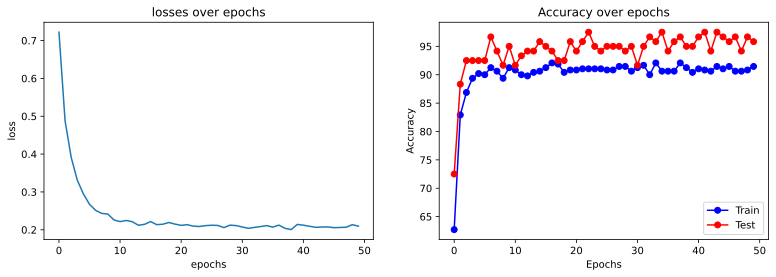

In [12]:
### Test the model once with a bit of data, just to make sure the code works.

# generate the data
theData = createSomeData(200)
train_loader = theData['train_data']
test_loader = theData['test_data']

# run the model 
trainAcc, testAcc, losses, net = function2trainTheModel(80, 1)

# show the results!
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

ax[0].plot(losses.detach())
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].set_title('losses over epochs')

ax[1].plot(trainAcc, 'bo-')
ax[1].plot(testAcc, 'ro-')
ax[1].set_title('Accuracy over epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Train', 'Test'])

plt.show()

## Now for the experiment!

In [13]:
# before the experiment, configure and confirm the metaparameters

# specify the parameters for the model
nNodesInModel = 80
layersRange = [1, 5, 10, 20]
nDataPoints = np.arange(50, 551, 50)

# create a legend for later plotting
legend = []

# print out the model architecture
for lidx, layers in enumerate(layersRange):

    # create a model
    unitsperLayer = int(nNodesInModel/layersRange[lidx])
    net = createTheQwertyNet(unitsperLayer, layers)[0]

    # count it's parameters
    nparams = np.sum([p.numel() for p in net.parameters() if p.requires_grad])

    legend.append('%s layers, %s units, %s params'%(layers, unitsperLayer, nparams))

    print('This model will have %s layers, each with %s units, totalling %s parameters'%(layers, unitsperLayer, nparams))




This model will have 1 layers, each with 80 units, totalling 6963 parameters
This model will have 5 layers, each with 16 units, totalling 1459 parameters
This model will have 10 layers, each with 8 units, totalling 771 parameters
This model will have 20 layers, each with 4 units, totalling 427 parameters


In [14]:
# note: takes ~5 mins

# initialize results matrix
results = np.zeros((len(nDataPoints),len(layersRange), 2))

for didx, pnts in enumerate(nDataPoints):

    # create data (note: same data for each layer manipulation!)
    theData = createSomeData(pnts)
    train_loader = theData['train_data']
    test_loader = theData['test_data']

    # now loop over layers
    for lidx, layers in enumerate(layersRange):

        unitsperlayer = int(nNodesInModel/layersRange[lidx])
        trainAcc, testAcc, losses, net = function2trainTheModel(unitsperlayer, layers)

        # average of last 5 accuracies and losses
        results[didx, lidx, 0] = np.mean(testAcc[-5:])
        results[didx, lidx, 1] = torch.mean(losses[-5:]).item()

        print(f'didx = {didx}, lidx = {lidx} is done...')




didx = 0, lidx = 0 is done...
didx = 0, lidx = 1 is done...
didx = 0, lidx = 2 is done...
didx = 0, lidx = 3 is done...
didx = 1, lidx = 0 is done...
didx = 1, lidx = 1 is done...
didx = 1, lidx = 2 is done...
didx = 1, lidx = 3 is done...
didx = 2, lidx = 0 is done...
didx = 2, lidx = 1 is done...
didx = 2, lidx = 2 is done...
didx = 2, lidx = 3 is done...
didx = 3, lidx = 0 is done...
didx = 3, lidx = 1 is done...
didx = 3, lidx = 2 is done...
didx = 3, lidx = 3 is done...
didx = 4, lidx = 0 is done...
didx = 4, lidx = 1 is done...
didx = 4, lidx = 2 is done...
didx = 4, lidx = 3 is done...
didx = 5, lidx = 0 is done...
didx = 5, lidx = 1 is done...
didx = 5, lidx = 2 is done...
didx = 5, lidx = 3 is done...
didx = 6, lidx = 0 is done...
didx = 6, lidx = 1 is done...
didx = 6, lidx = 2 is done...
didx = 6, lidx = 3 is done...
didx = 7, lidx = 0 is done...
didx = 7, lidx = 1 is done...
didx = 7, lidx = 2 is done...
didx = 7, lidx = 3 is done...
didx = 8, lidx = 0 is done...
didx = 8, 

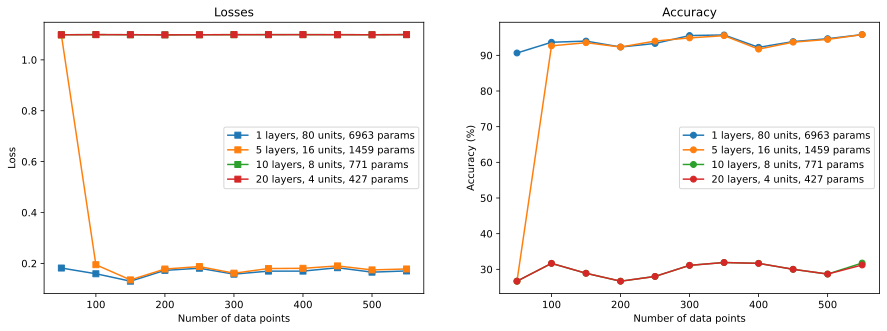

In [16]:
# show the results!
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(nDataPoints, results[:, :, 1], 's-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Number of data points')
ax[0].legend(legend)
ax[0].set_title('Losses')

ax[1].plot(nDataPoints, results[:, :, 0], 'o-')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Number of data points')
ax[1].set_title('Accuracy')
ax[1].legend(legend)
plt.show()